In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
eps = 0.01

def FGSM(model, x, y, epsilon = eps):
    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)
    gradient = tape.gradient(loss, x)
    signed_grad = tf.sign(gradient)
    adv_x = x + epsilon * signed_grad
    adv_x = tf.clip_by_value(adv_x, 0.0, 1.0)
    return adv_x

In [13]:
path = "./ORL3232/"
folders = sorted(os.listdir(path)[:-1], key = lambda x : int(x))

imgs = []
labels = []

for folder in folders:
    p = path + folder + '/'
    files = os.listdir(p)
    files = [p+x for x in files if x.endswith(".bmp")]
    for file in files:
        img = cv2.imread(file, 0) / 255.0
        imgs.append(np.reshape(img, [32, 32, 1]))
        labels.append(int(folder) - 1)

print("done")

done


In [14]:
x_data = imgs.copy()
y_data = labels.copy()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

x_train = tf.constant(x_train, dtype=tf.float32)
x_train = tf.concat([x_train, x_train], 0)
y_train = tf.one_hot(y_train, len(folders))
y_train = tf.concat([y_train, y_train], 0)

x_test = tf.constant(x_test, dtype=tf.float32)
y_test = tf.one_hot(y_test, len(folders))

assert x_train.shape[0] == y_train.shape[0]

Normal Training

In [15]:
class Model(keras.models.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pool = keras.layers.MaxPool2D()
        self.flat = keras.layers.Flatten()
        self.conv1 = keras.layers.Conv2D(24, 3, activation=tf.nn.relu)
        self.conv2 = keras.layers.Conv2D(16, 3, activation=tf.nn.relu)
        self.conv3 = keras.layers.Conv2D(12, 3, activation=tf.nn.relu)
        self.layer1 = keras.layers.Dense(64, activation=tf.nn.relu)
        self.layer2 = keras.layers.Dense(64, activation=tf.nn.relu)
        self.layer3 = keras.layers.Dense(40, activation=tf.nn.softmax)
        
    def call(self, input):
        x = input
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.flat(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [16]:
model = Model()
model.compile(keras.optimizers.Adam(), tf.losses.categorical_crossentropy, tf.metrics.categorical_accuracy)

history = model.fit(x_train, y_train, batch_size=8, epochs=50)

Epoch 1/50
80/80 [==============================] - 1s 4ms/step - loss: 3.6908 - categorical_accuracy: 0.0188
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 3.6866 - categorical_accuracy: 0.0297
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 3.6836 - categorical_accuracy: 0.0359
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 3.6733 - categorical_accuracy: 0.0312
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 3.6325 - categorical_accuracy: 0.0453
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 3.3882 - categorical_accuracy: 0.0922
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 2.9107 - categorical_accuracy: 0.1766
Epoch 8/50
80/80 [==============================] - 0s 5ms/step - loss: 2.2832 - categorical_accuracy: 0.3359
Epoch 9/50
80/80 [==============================] - 0s 4ms/step - loss: 1.7774 - categorical_accuracy: 0.4547
Epoch 10/5

In [17]:
print("Accuracy of clean data : {}".format(model.evaluate(x_test, y_test, verbose=0)[1]))

adv_x = FGSM(model, x_test, y_test)
rights = tf.reduce_sum(tf.where(tf.argmax(model.predict(adv_x, verbose=0), 1) == tf.argmax(y_test, 1), 1, 0)).numpy()
print("Accuracy of adversarial data : {}".format(rights / x_test.shape[0]))

Accuracy of clean data : 0.875
Accuracy of adversarial data : 0.4


Adversarial Training

In [18]:
class AdversarialModel(Model):
    def __init__(self, base_model, epsilon):
        super(AdversarialModel, self).__init__()
        self.base_model = base_model
        self.epsilon = epsilon

    def fgsm_attack(self, x, y):
        with tf.GradientTape() as tape:
            tape.watch(x)
            predictions = self.base_model(x)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        gradient = tape.gradient(loss, x)
        signed_grad = tf.sign(gradient)
        adv_x = x + self.epsilon * signed_grad
        adv_x = tf.clip_by_value(adv_x, 0.0, 1.0)
        return adv_x

    def call(self, inputs, training = False):
        if training:
            x, y = inputs 
            adv_x = self.fgsm_attack(x, y)  
            clean_preds = self.base_model(x)
            adv_preds = self.base_model(adv_x)
            return tf.concat([clean_preds, adv_preds], 0)
        else:
            x = inputs 
            return self.base_model(x)

@tf.function
def adversarial_loss(y_true, y_pred):
    size = y_pred.shape[0] // 2
    clean_preds, adv_preds = tf.split(y_pred, [size, size])
    loss_clean = tf.keras.losses.categorical_crossentropy(y_true, clean_preds)
    loss_adv = tf.keras.losses.categorical_crossentropy(y_true, adv_preds)
    return 0.5 * tf.reduce_mean(loss_clean) + 0.5 * tf.reduce_mean(loss_adv)

In [19]:
model_copy = Model()
model_copy(tf.expand_dims(x_test[0], 0))
model_copy.set_weights(model.get_weights())

model_adv = AdversarialModel(model_copy, epsilon=eps)
model_adv.compile(keras.optimizers.Adam(), adversarial_loss)
history_adv = model_adv.fit((x_train, y_train), y_train, batch_size=8, epochs=50)

Epoch 1/50
80/80 [==============================] - 3s 9ms/step - loss: 0.6926
Epoch 2/50
80/80 [==============================] - 1s 10ms/step - loss: 0.3704
Epoch 3/50
80/80 [==============================] - 1s 10ms/step - loss: 0.3928
Epoch 4/50
80/80 [==============================] - 1s 9ms/step - loss: 0.2204
Epoch 5/50
80/80 [==============================] - 1s 9ms/step - loss: 0.2995
Epoch 6/50
80/80 [==============================] - 1s 9ms/step - loss: 0.2818
Epoch 7/50
80/80 [==============================] - 1s 9ms/step - loss: 0.2642
Epoch 8/50
80/80 [==============================] - 1s 9ms/step - loss: 0.2114
Epoch 9/50
80/80 [==============================] - 1s 9ms/step - loss: 0.2018
Epoch 10/50
80/80 [==============================] - 1s 9ms/step - loss: 0.1463
Epoch 11/50
80/80 [==============================] - 1s 10ms/step - loss: 0.1296
Epoch 12/50
80/80 [==============================] - 1s 9ms/step - loss: 0.1206
Epoch 13/50
80/80 [===========================

In [20]:
rights = tf.reduce_sum(tf.where(tf.argmax(model_adv.predict(x_test, verbose=0), 1) == tf.argmax(y_test, 1), 1, 0)).numpy()
print("Accuracy of clean data : {}".format(rights / x_test.shape[0]))

adv_x = FGSM(model_adv, x_test, y_test)
rights = tf.reduce_sum(tf.where(tf.argmax(model_adv.predict(adv_x, verbose=0), 1) == tf.argmax(y_test, 1), 1, 0)).numpy()
print("Accuracy of adversarial data : {}".format(rights / x_test.shape[0]))

Accuracy of clean data : 0.925
Accuracy of adversarial data : 0.7125


Visualization

In [26]:
def display_images(img, adv_img):
    fig, axes = plt.subplots(2, 2)
    epsilons = [0, eps]
    descriptions = ['Epsilon = {:0.3f}'.format(eps) for eps in epsilons]
    for i in range(2):
        for j in range(2):
            description = "Origin Model, " + descriptions[i] if j == 0 else "Adv Model, " + descriptions[i]
            if i == 0:
                pred = model.predict(img, verbose=0) if j == 0 else model_adv.predict(img, verbose=0)
                label = tf.argmax(pred, -1)[0]
                confidence = pred[0, label]
                axes[i, j].imshow(cv2.cvtColor(img[0].numpy(), cv2.COLOR_BGR2RGB))
                axes[i, j].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
                axes[i, j].axis('off')
            else:
                pred = model.predict(adv_img[0], verbose=0) if j == 0 else model_adv.predict(adv_img[1], verbose=0)
                label = tf.argmax(pred, -1)[0]
                confidence = pred[0, label]
                axes[i, j].imshow(cv2.cvtColor(adv_img[j][0].numpy(), cv2.COLOR_BGR2RGB))
                axes[i, j].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

True Label : 38


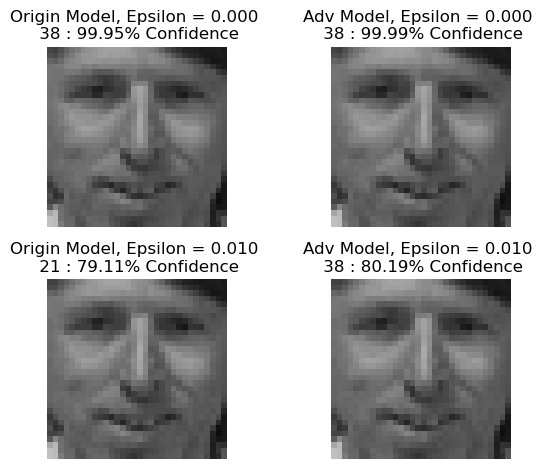

In [27]:
for i in range(x_test.shape[0]):
    image = tf.expand_dims(x_test[i], 0)
    label = tf.expand_dims(y_test[i], 0)
    if(tf.argmax(model.predict(image, verbose=0), -1)[0] == tf.argmax(label, -1)[0]):
        adv_x = [FGSM(model, image, label), FGSM(model_adv, image, label)]
        if(tf.argmax(model.predict(image, verbose=0), -1)[0] != tf.argmax(model.predict(adv_x[0], verbose=0), -1)[0]):
            if(tf.argmax(model_adv.predict(image, verbose=0), -1)[0] == tf.argmax(model_adv.predict(adv_x[1], verbose=0), -1)[0]):
                print("True Label : {}".format(tf.argmax(label, -1)[0].numpy()))
                display_images(image, adv_x)
                break